## Airline Sentiment Analysis

#### Import Libraries

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import AUC
from keras.utils import to_categorical
from gensim.models import Word2Vec


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#### Load data

In [3]:
# Load data
data = pd.read_csv('../data/Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Data Exploration and Preprocessing

In [4]:
# Check nulls and dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [5]:
# Check descriptive statistics
data.describe(include=[object]).T

,count,unique,top,freq
airline_sentiment,14640,3,negative,9178
negativereason,9178,10,Customer Service Issue,2910
airline,14640,6,United,3822
airline_sentiment_gold,40,3,negative,32
name,14640,7701,JetBlueNews,63
negativereason_gold,32,13,Customer Service Issue,12
text,14640,14427,@united thanks,6
tweet_coord,1019,832,"[0.0, 0.0]",164
tweet_created,14640,14247,2015-02-24 09:54:34 -0800,5
tweet_location,9907,3081,"Boston, MA",157


In [6]:
# Extract postice and negatives reviews
data = data.loc[data['airline_sentiment']!= 'neutral']
data = data[["airline_sentiment", "text"]]
data['airline_sentiment'] = data['airline_sentiment'].map({'positive': 1, 'negative': 0})
data

,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
5,0,@VirginAmerica seriously would pay $30 a fligh...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...
14634,0,@AmericanAir right on cue with the delays👌
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...


In [7]:
# Download stopwords 
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/jacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Function to preprocess and clean text 
def preprocess_text(text):
    # Normalize and remove specaial characters
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    # Split text and remove stop words
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    words = ' '.join(words)
    return words


# Preprocess text data
data['text'] = data['text'].apply(preprocess_text)

In [9]:
data['text'].iloc[0:5]

1    virginamerica plus added commercial experience...
3    virginamerica really aggressive blast obnoxiou...
4                   virginamerica really big bad thing
5    virginamerica seriously would pay 30 flight se...
6    virginamerica yes nearly every time fly vx ear...
Name: text, dtype: object

In [10]:
# Extract text and labels 
texts = data['text'].tolist()
labels = data['airline_sentiment'].tolist()

Text(0.5, 1.0, 'Distribution of Sentiments')

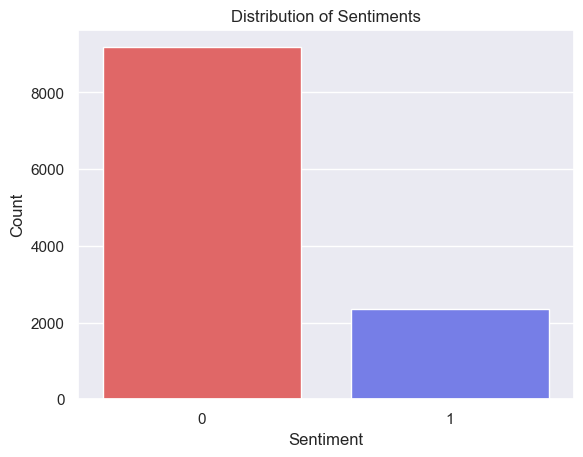

In [11]:
# Create a countplot
sns.set(style="darkgrid")
palette = {1: '#636efa', 0: '#f45353'}  # Define colors for each sentiment
sns.countplot(x=labels, palette=palette)

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

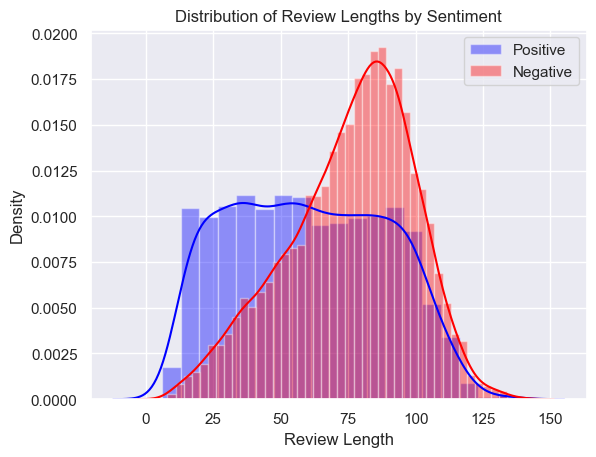

In [12]:
# Calculate the lengths of the reviews
positive_lengths = [len(text) for text, label in zip(texts, labels) if label == 1]
negative_lengths = [len(text) for text, label in zip(texts, labels) if label == 0]

# Create distplot
sns.distplot(positive_lengths, label='Positive', color='blue')
sns.distplot(negative_lengths, label='Negative',color='red')

plt.xlabel('Review Length')
plt.ylabel('Density')
plt.title('Distribution of Review Lengths by Sentiment')
plt.legend()

plt.show()


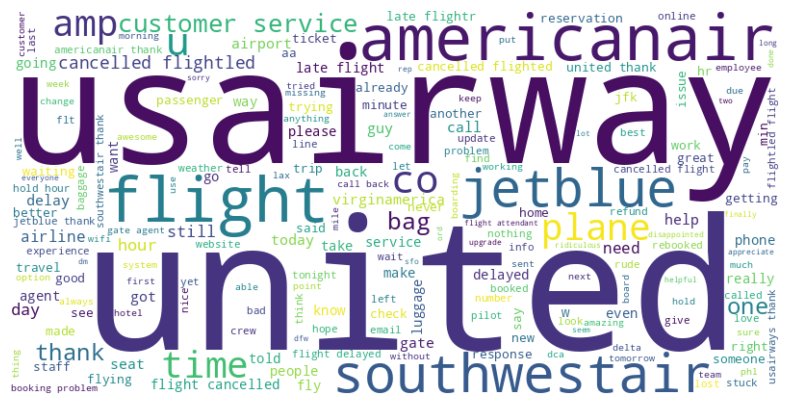

In [13]:
from wordcloud import WordCloud

# Combine all texts into a single string
all_text = ' '.join(texts)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Show the plot
plt.show()

#### Vectorization

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform
X = tfidf_vectorizer.fit_transform(texts)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


#### Model Experimentation

In [ ]:
# Intialize Random Forest model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Evaluate model
accuracy = rf.score(X_test, y_test)
print(f'Accuracy - Random Forest: {accuracy * 100:.2f}%')


In [ ]:
# Intialize XgboostClassifier 
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate model
accuracy = xgb_model.score(X_test, y_test)
print(f'Accuracy - XGBoostClassifier: {accuracy * 100:.2f}%')

In [ ]:
# Hyperparameter tuning using GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5]
}

In [ ]:
# Initialize XgboostClassifier 
xgb_model = XGBClassifier(random_state=42)

# Initialize GridSearchCV with scoring set to 'roc_auc'
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3)

# Train the GridSearch
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Save the model
import joblib
joblib.dump(best_model, '../models/best_model.pkl')

In [ ]:
# Load the model
best_model = joblib.load('../models/best_model.pkl')

# Evaluate the model
accuracy = best_model.score(X_test, y_test)
print(f'Accuracy of XGBoost: {accuracy * 100:.2f}%')
print(f'Best Hyperparameters: {best_params}')

#### Model Evalutation

In [ ]:
from sklearn.metrics import roc_curve, auc

# get the predicted probabilities of class 1
predicted = best_model.predict_proba(X_test)[:,1] 

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
sns.set_style("darkgrid")
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
sns.lineplot(data=roc_df, x='fpr', y='tpr', color='blue', label=f'AUC={roc_auc:.4f}')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# Display confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBoost Classifier: {0}'.format(best_model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

#### Model Prediction

In [ ]:
# Make predictions
predictions = best_model.predict(X_test)

# Create a list of positive and negative sentences based on predicted labels 
positive_sentences = [X_test[i] for i in range(len(predictions)) if predictions[i] == 1]
negative_sentences = [X_test[i] for i in range(len(predictions)) if predictions[i] == 0]

# Convert the sentences back to their original text form
positive_texts = [tfidf_vectorizer.inverse_transform(sentence)[0] for sentence in positive_sentences]
negative_texts = [tfidf_vectorizer.inverse_transform(sentence)[0] for sentence in negative_sentences]

# Print the first 5 positive and negative texts
print("Positive Texts:")
for text in positive_texts[:5]:
    print(' '.join(text))

print("\nNegative Texts:")
for text in negative_texts[:5]:
    print(' '.join(text))


### Deep Learning approach

#### Tokenization

In [14]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Create sequences 
sequences = tokenizer.texts_to_sequences(texts)
max_seq_len = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

#### Word2Vec Embeddings

In [15]:
# Create list of tokenized sentences 
sentences = [text.split() for text in texts]

embedding_dim = 100

# Initialize and train Word2Vec model
word2vec = Word2Vec(
    sentences, 
    vector_size=embedding_dim, 
    window=5,
    min_count=1,
    sg=0
)

In [16]:
# Check similar words
sims = word2vec.wv.most_similar('american', topn=10)
sims

[('company', 0.9993074536323547),
 ('always', 0.9992948174476624),
 ('southwest', 0.9992760419845581),
 ('virginamerica', 0.9992156028747559),
 ('aa', 0.9991560578346252),
 ('good', 0.9991492033004761),
 ('world', 0.9991446733474731),
 ('sure', 0.9991267323493958),
 ('complaint', 0.9990995526313782),
 ('treated', 0.9990956783294678)]

In [17]:
# Create embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[word] # add vector representation to embedding matrix

embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.83177722e-01,  1.04157019e+00, -4.27756570e-02, ...,
        -2.04657778e-01,  3.54904473e-01, -2.89703608e-01],
       [-7.43712544e-01,  7.92958379e-01, -2.18129888e-01, ...,
        -4.86374646e-01,  4.04963911e-01, -7.95317739e-02],
       ...,
       [-2.80052365e-04,  2.89246178e-04, -1.09885316e-02, ...,
        -1.43761479e-03, -1.44666724e-03,  1.70105149e-03],
       [-1.23392530e-02,  1.01003805e-02, -1.26778055e-02, ...,
         8.53508769e-04,  9.74546466e-03, -1.12983119e-03],
       [-2.95328419e-03,  5.38209127e-03, -3.81106324e-03, ...,
        -1.25011802e-02,  1.67242438e-02, -1.03823403e-02]])

#### LSTM Model

In [18]:
# Define the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim,
                weights=[embedding_matrix], input_length=max_seq_len, trainable=False),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(2, activation="softmax")
])

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-09-08 21:05:08.203744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-08 21:05:08.203880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 100)           1175500   
                                                                 
 lstm (LSTM)                 (None, 26, 64)            42240     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 1,250,894
Trainable params: 75,394
Non-trainable params: 1,175,500
_________________________________________________________________


In [20]:
# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', AUC()])

In [21]:
# One hot encode labels
y = to_categorical(labels, num_classes=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# Train the model
history = model.fit(X_train,
                    y_train, 
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32)

Epoch 1/10


2023-09-08 21:05:08.785010: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-08 21:05:09.631833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:05:09.862429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:05:09.983228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:05:10.174828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/271 [..............................] - ETA: 7:51 - loss: 0.7008 - accuracy: 0.4062 - auc: 0.2563

2023-09-08 21:05:10.385842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7995 - auc: 0.8693

2023-09-08 21:05:19.554596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:05:19.658406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:05:19.739859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


271/271 [==============================] - 13s 41ms/step - loss: 0.4538 - accuracy: 0.7995 - auc: 0.8693 - val_loss: 0.4332 - val_accuracy: 0.8049 - val_auc: 0.8866
Epoch 2/10
271/271 [==============================] - 10s 37ms/step - loss: 0.4267 - accuracy: 0.8083 - auc: 0.8853 - val_loss: 0.4113 - val_accuracy: 0.8299 - val_auc: 0.9021
Epoch 3/10
271/271 [==============================] - 10s 37ms/step - loss: 0.4084 - accuracy: 0.8202 - auc: 0.8955 - val_loss: 0.3953 - val_accuracy: 0.8299 - val_auc: 0.9039
Epoch 4/10
271/271 [==============================] - 10s 38ms/step - loss: 0.4012 - accuracy: 0.8258 - auc: 0.8990 - val_loss: 0.3709 - val_accuracy: 0.8451 - val_auc: 0.9158
Epoch 5/10
271/271 [==============================] - 10s 37ms/step - loss: 0.3851 - accuracy: 0.8357 - auc: 0.9076 - val_loss: 0.3708 - val_accuracy: 0.8465 - val_auc: 0.9197
Epoch 6/10
271/271 [==============================] - 10s 37ms/step - loss: 0.3740 - accuracy: 0.8424 - auc: 0.9130 - val_loss: 0.3

In [23]:
# Plot loss and metrics
epochs = range(1, len(history.history['loss']) + 1)
def plot_metric(epochs, train_metric, val_metric, metric_name):
    plt.plot(epochs, train_metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Testing {metric_name}')
    plt.title(f'Training vs Test {metric_name}')
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(False)
    plt.show()


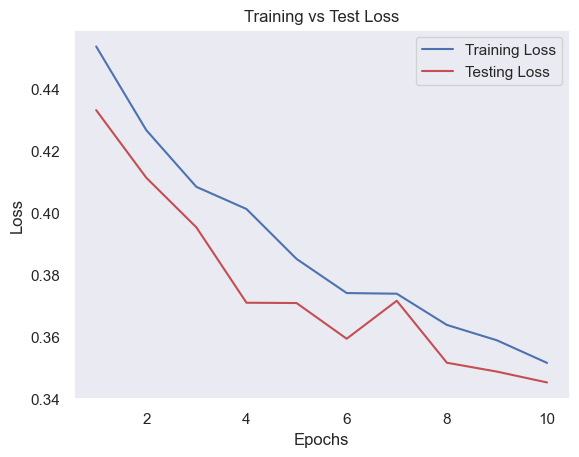

<Figure size 640x480 with 0 Axes>

In [24]:
plot_metric(epochs, history.history['loss'], history.history['val_loss'], 'Loss')
plt.savefig('../images/model_loss.png')

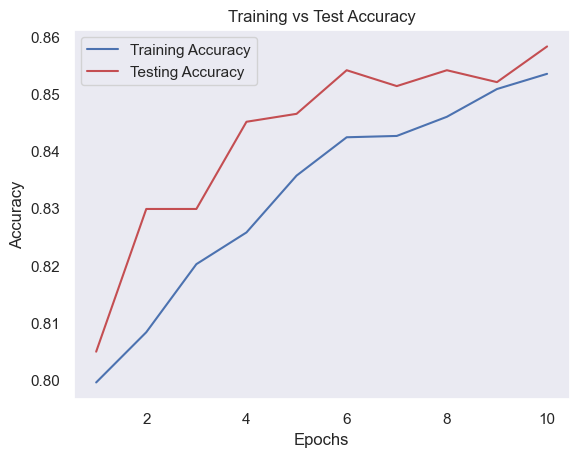

<Figure size 640x480 with 0 Axes>

In [25]:
plot_metric(epochs, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')
plt.savefig('../images/model_acc.png')

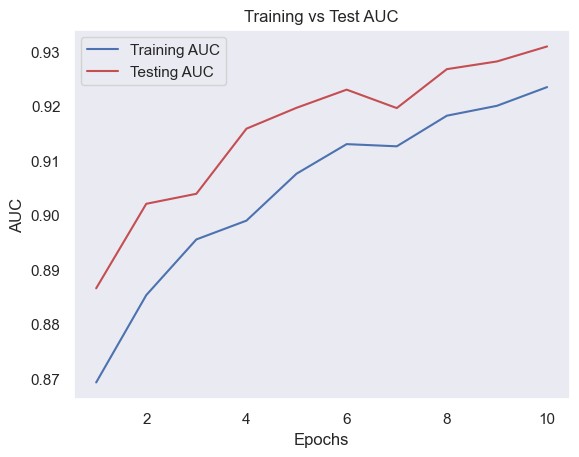

<Figure size 640x480 with 0 Axes>

In [26]:
plot_metric(epochs, history.history['auc'], history.history['val_auc'], 'AUC')
plt.savefig('../images/model_auc.png')

In [27]:
# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f'Val Loss: {results[0]:.2f}')
print(f'Val Accuracy: {results[1] * 100:.2f}%')
print(f'Val AUC: {results[2]:.4f}')

91/91 [==============================] - 2s 21ms/step - loss: 0.3451 - accuracy: 0.8583 - auc: 0.9309
Val Loss: 0.35
Val Accuracy: 85.83%
Val AUC: 0.9309


In [28]:
from keras.callbacks import ModelCheckpoint

filepath = "../models/best_model.h5"

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

# Train the model 
history_1 = model.fit(X_train,
                    y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[checkpoint])

Epoch 1/50
271/271 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8511 - auc: 0.9239
Epoch 1: val_auc improved from -inf to 0.92607, saving model to ../models/best_model.h5
271/271 [==============================] - 10s 39ms/step - loss: 0.3511 - accuracy: 0.8511 - auc: 0.9239 - val_loss: 0.3465 - val_accuracy: 0.8524 - val_auc: 0.9261
Epoch 2/50
271/271 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8547 - auc: 0.9277
Epoch 2: val_auc improved from 0.92607 to 0.92753, saving model to ../models/best_model.h5
271/271 [==============================] - 10s 38ms/step - loss: 0.3425 - accuracy: 0.8547 - auc: 0.9277 - val_loss: 0.3575 - val_accuracy: 0.8496 - val_auc: 0.9275
Epoch 3/50
271/271 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8545 - auc: 0.9282
Epoch 3: val_auc improved from 0.92753 to 0.93407, saving model to ../models/best_model.h5
271/271 [==============================] - 10s 38ms/step - loss: 0.341

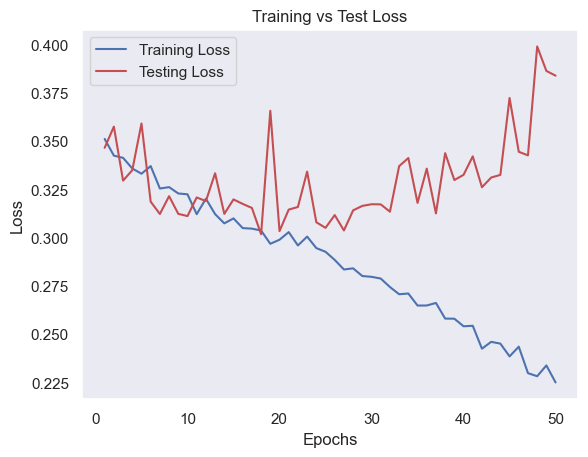

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot the loss and metics
epochs = range(1, len(history_1.history['loss']) + 1)
plot_metric(epochs, history_1.history['loss'], history_1.history['val_loss'], 'Loss')
plt.savefig('../images/best_model_loss.png')

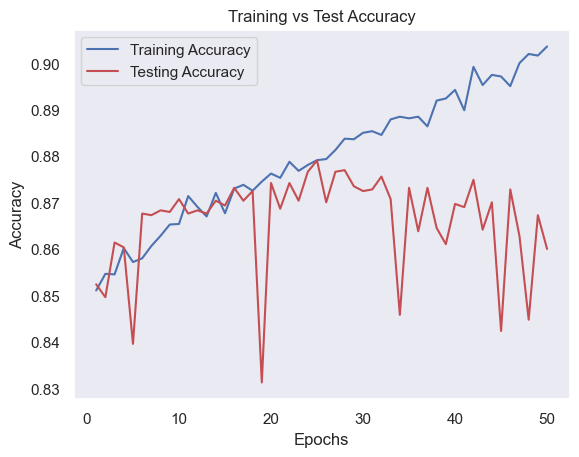

<Figure size 640x480 with 0 Axes>

In [30]:
plot_metric(epochs, history_1.history['accuracy'], history_1.history['val_accuracy'], 'Accuracy')
plt.savefig('../images/best_model_acc.png')

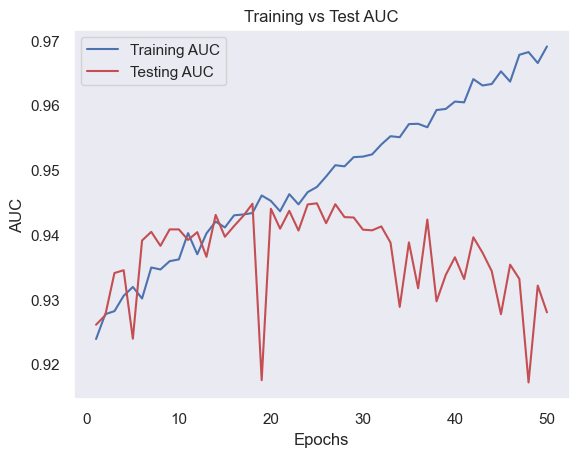

<Figure size 640x480 with 0 Axes>

In [31]:
plot_metric(epochs, history_1.history['auc'], history_1.history['val_auc'], 'AUC')
plt.savefig('../images/best_model_auc.png')

#### Model Evaluation

In [32]:
from keras.models import load_model

# Load best model
best_model = load_model(filepath)

# Evaluate the model
results = best_model.evaluate(X_test, y_test)
print(f'Val Loss: {results[0]:.2f}')
print(f'Val Accuracy: {results[1] * 100:.2f}%')
print(f'Val AUC: {results[2]:.4f}')

2023-09-08 21:15:32.336434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:15:32.439932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:15:32.524777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 3s 22ms/step - loss: 0.3051 - accuracy: 0.8791 - auc: 0.9448
Val Loss: 0.31
Val Accuracy: 87.91%
Val AUC: 0.9448


#### Model Predictions

In [33]:
# Make predictions
predictions = best_model.predict(X_test)

# Predictions willl be probability scores for each clas, so you can covnert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create list of positive and negative snetences based on predicted labels 
positive_sentences = [X_test[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 1]
negative_sentences = [X_test[i] for i in range(len(predicted_labels)) if predicted_labels[i] == 0]

positive_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in positive_sentences]
negative_texts = [tokenizer.sequences_to_texts([sentence])[0] for sentence in negative_sentences]

positive_texts[:5]

2023-09-08 21:15:34.862769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:15:34.936407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-08 21:15:35.020748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 1s 12ms/step


['jetblue great flight great view http co yxn00pnoav',
 'united thank one month ago none weird club one busiest airport u',
 'americanair great thanks followed',
 'united got thanks',
 'virginamerica look like broken link asset http co oardjjgrrd']

In [34]:
negative_texts[:5]

['usairways charged flight cancelled flightled unbelievable unheard',
 'united actually gate agent rude standing line waiting reflight booking problem missed flight sti awful',
 'americanair worry called back 4 hr late flightr asleep took additional 200 fee aa standard everything gr8',
 'united brother luggage lost copa airline flight 635 competing sunday 2015 panamerican cross country cup please help',
 'usairways work hard making sure thing flow smoothly keeping positive']